<a href="https://colab.research.google.com/github/ivarbratberg/intro-to-dl/blob/master/week5/RNN-task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set tf 1.x for colab
%tensorflow_version 1.x
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week2_honor()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

TensorFlow 1.x selected.
--2020-05-28 14:19:54--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-05-28 14:19:54 (55.3 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]



In [0]:
# set tf 1.x for colab
%tensorflow_version 1.x

# Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [3]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils
import tqdm_utils

1.15.2


Using TensorFlow backend.


# Load data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [0]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [5]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)

number of samples: 7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length: 16


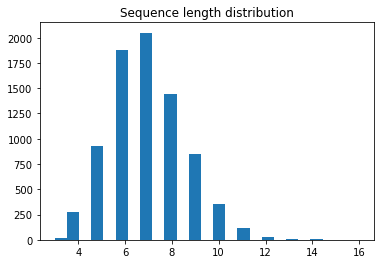

In [6]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

# Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [29]:
### YOUR CODE HERE: all unique characters go here, padding included!
#all unique characters go here
tokens = set(''.join(names))

tokens = list(tokens)
tokens.append(pad_token)

n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)

assert 50 < n_tokens < 60

n_tokens =  56


### Cast everything from symbols into identifiers

Tensorflow string manipulation is a bit tricky, so we'll work around it. 
We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign `token_to_id`

In [30]:
token_to_id = {symbol : index for symbol,index in zip(tokens,range(len(tokens)))}
###YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens }
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
print(token_to_id)

{'Q': 0, 'U': 1, 'e': 2, 'D': 3, 'v': 4, 'g': 5, ' ': 6, 'q': 7, 't': 8, 'b': 9, 's': 10, 'Y': 11, 'P': 12, 'x': 13, 'l': 14, 'm': 15, 'R': 16, '-': 17, 'J': 18, 'V': 19, 'c': 20, 'C': 21, 'Z': 22, 'K': 23, 'F': 24, 'B': 25, 'G': 26, 'z': 27, 'L': 28, 'y': 29, 'd': 30, 'M': 31, 'S': 32, 'T': 33, 'h': 34, 'W': 35, 'u': 36, 'p': 37, 'H': 38, 'X': 39, 'O': 40, 'r': 41, 'i': 42, 'E': 43, 'k': 44, 'A': 45, "'": 46, 'o': 47, 'f': 48, 'I': 49, 'N': 50, 'n': 51, 'j': 52, 'w': 53, 'a': 54, '#': 55}


In [0]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [32]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[ 6 45  9 54  5 54  2 14 55]
 [ 6 26 14 47 41 29 55 55 55]
 [ 6 12 41 42 10 10 42  2 55]
 [ 6 26 42 47  4 54 51 51  2]]


# Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="https://github.com/ivarbratberg/intro-to-dl/blob/master/week5/rnn.png?raw=1" width=600>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme based on h_t+1

In [0]:
# remember to reset your session if you change your graph!
s = keras_utils.reset_tf_session()

In [0]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# Let's create layers for our recurrent network
# Note: we create layers but we don't "apply" them yet (this is a "functional API" of Keras)
# Note: set the correct activation (from keras.activations) to Dense layers!

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
### YOUR CODE HERE

get_h_next = Dense(rnn_num_units, activation='tanh')

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
### YOUR CODE HERE 
get_probas = Dense(n_tokens, activation = 'softmax')


We will generate names character by character starting with `start_token`:

<img src="https://github.com/ivarbratberg/intro-to-dl/blob/master/week5/char-nn.png?raw=1" width=600>

In [0]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    
    You're supposed to "apply" above layers to produce new tensors.
    Follow inline instructions to complete the function.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    #  ## YOUR CODE HERE
    x_and_h = concatenate([x_t_emb, h_t])
    
    # compute next state given x_and_h
    ### YOUR CODE HERE
    h_next = get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    ### YOUR CODE HERE
    output_probas = get_probas(h_next)
    
    return output_probas, h_next

# RNN: loop

Once `rnn_one_step` is ready, let's apply it in a loop over name characters to get predictions.

Let's assume that all names are at most length-16 for now, so we can simply iterate over them in a for loop.


In [0]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

In [37]:
import numpy as np
a = np.random.rand(3,3)
print(a)
print(a[:,:-1])

[[0.38717043 0.52007813 0.9625249 ]
 [0.93932332 0.2040593  0.65760432]
 [0.3021266  0.89041928 0.15562938]]
[[0.38717043 0.52007813]
 [0.93932332 0.2040593 ]
 [0.3021266  0.89041928]]


# RNN: loss and gradients

Let's gather a matrix of predictions for $P(x_{next}|h)$ and the corresponding correct answers.

We will flatten our matrices to shape [None, n_tokens] to make it easier.

Our network can then be trained by minimizing crossentropy between predicted probabilities and those answers.

In [0]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)


In [39]:
import tensorboard
print(input_sequence.shape)
print(predictions_matrix.shape)
print(answers_matrix.shape)
print(n_tokens)
# answers_matrix.shape

(?, 16)
(?, 56)
(?, 56)
56


Usually it's a good idea to ignore gradients of loss for padding token predictions.

Because we don't care about further prediction after the pad_token is predicted for the first time, so it doesn't make sense to punish our network after the pad_token is predicted.

For simplicity you can ignore this comment, it's up to you.

## Loss
SoftMax will give prob(class) exp(class_i)/sum(class_...)
Cross Entropy loss will be sum og props when not belonging to this class
The logit function is what is calculated from the dense function

### Variables used
answer_matrix contains probabillities for each, that means 1 for the predicedt and 0 for the rest
predictions_matrix contains predictions for al

## Training
We take a batches and feed it and for each batch the weights are trained


In [0]:
# Define the loss as categorical cross-entropy (e.g. from keras.losses).
# Mind that predictions are probabilities and NOT logits!
# Remember to apply tf.reduce_mean to get a scalar loss!
### YOUR CODE HERE
from keras.losses import categorical_crossentropy
loss = tf.reduce_mean(categorical_crossentropy(answers_matrix, predictions_matrix))

optimize = tf.train.AdamOptimizer().minimize(loss)

# RNN: training

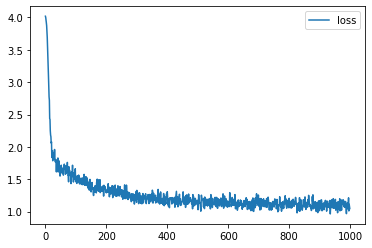

In [41]:
from IPython.display import clear_output
from random import sample
 
s.run(tf.global_variables_initializer())
# s.run( tf.initialize_all_variables())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

# RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` function you have written above.

In [0]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

# For sampling we need to define `rnn_one_step` tensors only once in our graph.
# We reuse all parameters thanks to functional API usage.
# Then we can feed appropriate tensor values using feed_dict in a loop.
# Note how different it is from training stage, where we had to unroll the whole sequence for backprop.
next_probs, next_h = rnn_one_step(x_t, h_t)

In [0]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [44]:
# without prefix
for _ in range(10):
    print(generate_sample())

 Sonsla
 Rusy
 Katemer
 Ragreli
 HIlpal
 Dlaldyrls
 Mirtha
 Har
 Darhyr
 Naminrde


In [45]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' Trump'))

 Trumpi
 Trumpes
 Trumpinge
 Trumpe
 Trumpa
 Trumpke
 Trumpeld
 Trump
 Trumpa
 Trumpile


# Submit to Coursera

In [0]:
# token expires every 30 min
COURSERA_TOKEN = "### YOUR TOKEN HERE ###"
COURSERA_EMAIL = "### YOUR EMAIL HERE ###"

In [0]:
from submit import submit_char_rnn
samples = [generate_sample(' Al') for i in tqdm_utils.tqdm_notebook_failsafe(range(25))]
submission = (history, samples)
submit_char_rnn(submission, COURSERA_EMAIL, COURSERA_TOKEN)

# Try it out!

__Disclaimer:__ This part of assignment is entirely optional. You won't receive bonus points for it. However, it's a fun thing to do. Please share your results on course forums.

You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* IKEA catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__

# Bonus level: dynamic RNNs

Apart from Keras, there's also a friendly TensorFlow API for recurrent neural nets. It's based around the symbolic loop function (aka [tf.scan](https://www.tensorflow.org/api_docs/python/tf/scan)).

RNN loop that we implemented for training can be replaced with single TensorFlow instruction: [tf.nn.dynamic_rnn](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn).
This interface allows for dynamic sequence length and comes with some pre-implemented architectures.

Take a look at [tf.nn.rnn_cell.BasicRNNCell](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicRNNCell).

In [0]:
class CustomRNN(tf.nn.rnn_cell.BasicRNNCell):
    def call(self, input, state):
        # from docs:
        # Returns:
        # Output: A 2-D tensor with shape [batch_size, self.output_size].
        # New state: Either a single 2-D tensor, or a tuple of tensors matching the arity and shapes of state.
        return rnn_one_step(input[:, 0], state)
    
    @property
    def output_size(self):
        return n_tokens
    
cell = CustomRNN(rnn_num_units)

input_sequence = tf.placeholder(tf.int32, (None, None))
    
predicted_probas, last_state = tf.nn.dynamic_rnn(cell, input_sequence[:, :, None], dtype=tf.float32)

print('LSTM outputs for each step [batch,time,n_tokens]:')
print(predicted_probas.eval({input_sequence: to_matrix(names[:10], max_len=50)}).shape)

Note that we never used MAX_LENGTH in the code above: TF will iterate over however many time-steps you gave it.

You can also use any pre-implemented RNN cell:

In [0]:
for obj in dir(tf.nn.rnn_cell) + dir(tf.contrib.rnn):
    if obj.endswith('Cell'):
        print(obj, end="\t")

In [0]:
input_sequence = tf.placeholder(tf.int32, (None, None))

inputs_embedded = embed_x(input_sequence)

# standard cell returns hidden state as output!
cell = tf.nn.rnn_cell.LSTMCell(rnn_num_units)

state_sequence, last_state = tf.nn.dynamic_rnn(cell, inputs_embedded, dtype=tf.float32)

s.run(tf.global_variables_initializer())

print('LSTM hidden state for each step [batch,time,rnn_num_units]:')
print(state_sequence.eval({input_sequence: to_matrix(names[:10], max_len=50)}).shape)